# Korg spectrum synthesis of Fornax with MAVIS

Author: Sven Buder (ANU, sven.buder@anu.edu.au)

Korg computes stellar spectra from 1D model atmospheres and linelists assuming local thermodynamic equilibrium.
If you make use of Korg, please cite [Wheeler et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023AJ....165...68W/abstract) as well as [Wheeler et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167...83W/abstract). For more information, take a look at Korg's [documentation](https://ajwheeler.github.io/Korg.jl/stable/).

This interface is meant to compute synthetic Korg spectra for Fornax at MAVIS (3700-9400Å) wavelength and resolution (R=20,000).

You need to have installed:
*julia*, and its packages *Korg*, *JLD2*, *FiloIO*, and *Serialization  *
2 the *python* package *juliacall*  
For further information on how to do this, you can take a look at the [Korg install documentation](https://ajwheeler.github.io/Korg.jl/stable/install/#install).

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic Packages
import numpy as np
import time
import os
import subprocess
import matplotlib.pyplot as plt

# Julia part: Korg for spectrum synthesis
try:
    from juliacall import Main as jl
    jl.seval("using Korg")
    Korg = jl.Korg
except ImportError as e:
    error_message = (
        f"Failed to import 'juliacall' in python and/or 'Korg' in julia. Please make sure it is installed. "
        f"Visit https://ajwheeler.github.io/Korg.jl/stable/ for installation instructions."
    )
    raise ImportError(error_message) from e

# Julia part: JLD, FileIO for LSF matrix
try:
    jl.seval("using JLD2, FileIO, Serialization")
except ImportError as e:
    try:
        jl.seval("using Pkg")
        jl.Pkg.add("JLD2")
        jl.Pkg.add("FileIO")
    except ImportError as e:
        error_message = (
            f"Failed to install 'JLD2' and 'File'."
        )
        raise ImportError(error_message) from e
    error_message = (
        f"Failed to import 'JLD2' and 'File' for julia."
    )
    raise ImportError(error_message) from e

# Korg input: wavelengths, line-spread-function matrix, linelist

In [2]:
# Create julia-array of Korg wavelengths (note: vacuum!)
korg_wavelength_vacuum_start = 3690
korg_wavelength_vacuum_step = 0.01
korg_wavelength_vacuum_end = 9410
korg_wavelength_vacuum = jl.seval('['+str(korg_wavelength_vacuum_start)+':'+str(korg_wavelength_vacuum_step)+':'+str(korg_wavelength_vacuum_end)+']')
korg_wavelength_air = np.array([Korg.vacuum_to_air(pixel) for pixel in np.arange(korg_wavelength_vacuum_start, korg_wavelength_vacuum_end+korg_wavelength_vacuum_step, korg_wavelength_vacuum_step)])

# Create python arrays of MAVIS wavelengths, both air and vacuum
mavis_wavelength_air_start = 3700
mavis_wavelength_air_step = 0.1
mavis_wavelength_air_end = 9400
mavis_wavelength_air = np.arange(mavis_wavelength_air_start, mavis_wavelength_air_end+mavis_wavelength_air_step, mavis_wavelength_air_step)
mavis_wavelength_vacuum = np.array([Korg.vacuum_to_air(pixel) for pixel in mavis_wavelength_air])

In [3]:
# Line-spread-function matrix computation.
# There is 2 ways to do it. Either via juliacall (slow), or via julia and then reading in the file via juliacall.
# Since we do not need to adjust the wavelength arrays, we can simply run it once in julia+save the file and then read it in here.
# For completeness, I am still showing you the slow way as well

# # LSF comptuation slow:
# # Compute the LSF to map from Korg onto MAVIS LSF. Here we assume R=20,000 for MAVIS
# lsf_compute_start = time.time()
# print('Starting to compute LSF matrix for Korg->MAVIS.\nThis may take some time, but you luckily only have to do it once.\nIit took Xs for my 16" MacBook Pro.\nA faster way could be to simply apply a Gaussian filter based on the velocity broadening of 299792.458 km/s / 20000 = 15.0 km/s.')
# korg_mavis_lsf = Korg.compute_LSF_matrix(
#     korg_wavelength_vacuum_vac,
#     mavis_wavelength_vacuum,
#     20_000)
# print('Done in '+"{:.1f}".format(time.time()-lsf_compute_start)+'s.')

# # LSF computation in julia
# # First execute in julia:
# """
# using Korg
# using JLD2, FileIO
# korg_wavelength_vacuum = 3690:0.01:9410
# mavis_wavelength_vacuum = 3700:0.1:9400
# korg_mavis_lsf = Korg.compute_LSF_matrix(
#            korg_wavelength_vacuum,
#            mavis_wavelength_vacuum,
#            20_000)
# @save "lsf_matrix_lsf_korg_mavis.jld2" korg_mavis_lsf
# """
# Now read in the file as sparse matrix:
jl.seval("""
function load_jld2_matrix(filepath)
    return load(filepath)["korg_mavis_lsf"]
end
""")
try:
    korg_mavis_lsf = jl.load_jld2_matrix("lsf_matrix_lsf_korg_mavis.jld2")
    print(f"LSF Matrix File read in successfully.")
except:
    url = 'https://www.mso.anu.edu.au/~buder/korg/lsf_matrix_lsf_korg_mavis.jld2'
    try:
        # Download the linelist using wget
        subprocess.check_call(['wget', url])
        print(f"LSF Matrix File downloaded successfully.")
        korg_mavis_lsf = jl.load_jld2_matrix("lsf_matrix_lsf_korg_mavis.jld2")
        print(f"LSF Matrix File read in successfully.")
    except subprocess.CalledProcessError as e:
        raise SystemExit(f"Failed to download file: {e}") from None

LSF Matrix File read in successfully.


In [4]:
# Try to read in VALD linelist with 1,834,576 lines.
# If not possible, download it and try again.
linelist_directory = 'linelists/'
linelist_path = os.path.join(linelist_directory, '3600_9500_0p01_3500_4.5_MH_0p5_long_withHFS.vald')
try:
    # This file is 835.4MB large
    korg_lines = Korg.read_linelist(linelist_path)
    print(f"Linelist '{linelist_path}' read successfully.")
except FileNotFoundError:
    url = 'https://www.mso.anu.edu.au/~buder/korg/linelists/3600_9500_0p01_3500_4.5_MH_0p5_long_withHFS.vald'
    print(f"File '{linelist_path}' not found. Downloading from {url}...")
    try:
        # Download the linelist using wget
        subprocess.check_call(['wget', '-P', linelist_directory, url])
        print(f"Linelist downloaded successfully to '{linelist_directory}'.")

        # Try to read the linelist again
        korg_lines = Korg.read_linelist(linelist_path)
        print(f"Linelist '{linelist_path}' read successfully.")
    except subprocess.CalledProcessError as e:
        raise SystemExit(f"Failed to download file: {e}") from None

Linelist 'linelists/3600_9500_0p01_3500_4.5_MH_0p5_long_withHFS.vald' read successfully.


# Korg synthesis call

In [5]:
def calculate_korg_spectrum(teff, logg, fe_h, vmic = 1.0, vsini=5.0, epsilon=0.6, normalise_flux=False, debug=False):
    """
    Calculate a synthetic stellar spectrum using the Korg library based on input stellar parameters.

    This function generates a spectrum by interpolating within a grid of pre-computed models
    according to the given stellar parameters. It can also apply rotational broadening and
    optionally normalise the resulting flux.

    Parameters:
    - teff (float): Effective temperature of the star in Kelvin.
    - logg (float): Logarithm (base 10) of the surface gravity in cm/s^2.
    - fe_h (float): Metallicity [Fe/H], representing the logarithmic iron abundance relative to hydrogen,
      compared to the Sun.
    - vmic (float, optional): Microturbulence velocity in km/s. Default is 1.0 km/s.
    - vsini (float, optional): Projected rotational velocity of the star in km/s. Default is 5.0 km/s.
    - epsilon (float, optional): Limb darkening coefficient, used in the rotational broadening. 
      It ranges from 0 to 1, where 0 means no limb darkening and 1 represents full limb darkening. 
      Default is 0.6.
    - normalise_flux (bool, optional): If True, the output flux will be normalised to 1. Default is False.
    - debug (bool, optional): If True, additional debug information will be printed during the computation. 
      Default is False.

    Returns:
    - spectrum (array-like): The calculated synthetic spectrum, which includes wavelengths and corresponding fluxes.
      The specific format of the output depends on the Korg library's conventions.

    Raises:
    - ValueError: If any of the input parameters are out of the acceptable range for the Korg library.

    Examples:
    - Calculate a simple spectrum:
        >>> calculate_korg_spectrum(5700, 4.5, -0.2)
    - Calculate a spectrum with rotational broadening and normalisation:
        >>> calculate_korg_spectrum(5700, 4.5, -0.2, vsini=10.0, normalise_flux=True)

    Note:
    This function assumes that the Korg library and necessary data files are correctly installed and configured.
    
    Korg computes stellar spectra from 1D model atmospheres and linelists assuming local thermodynamic equilibrium.
    If you make use of Korg, please cite [Wheeler et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023AJ....165...68W/abstract) as well as [Wheeler et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167...83W/abstract). For more information, take a look at Korg's [documentation](https://ajwheeler.github.io/Korg.jl/stable/).

    This interface is meant to compute synthetic Korg spectra for Fornax at MAVIS (3700-9400Å) wavelength and resolution (R=20,000).
    """

    # Create parameter dictionary
    fixed_parameters = {'teff':teff, 'logg':logg, 'fe_h':fe_h, 'vmic':vmic, 'vsini':vsini, 'epsilon':epsilon}
    
    if debug:
        start_time = time.time()
        print('Calculating Korg spectrum with fixed parameters: ',fixed_parameters)
    
    # Create the A(X) dictionary for synthesising lines with Korg
    # Korg can use fe_h and alpha_h, or even individual abundances as input.
    # For this computation, we assume the standard alpha-enhancement, i.e.
    # [alpha/Fe] = 0.4 for [Fe/H] < -1.0
    # [alpha/Fe] = 0.0 for [Fe/H] > 0.0
    # [alpha/Fe] = -0.4 * fe_h below
    alpha_fe = -0.4 * fe_h
    if alpha_fe > 0.4: alpha_fe = 0.4
    if alpha_fe < 0.0: alpha_fe = 0.0
    # transform alpha_fe into alpha_h
    alpha_h = alpha_fe + fe_h
    # finally create Korg's abundance dictionary
    a_x_dictionary = Korg.format_A_X(fe_h, alpha_h)
    if debug:
        print('   --> A(X) scale assumes Asplund et al. (2021), and [alpha/Fe]='+str(alpha_fe)+' (i.e. [alpha/H]='+str(alpha_h)+')')
        a_x_time = time.time()

        print('   --> Interpolating extended MARCS model atmosphere')
    # Interpolate the MARCS model atmosphere
    atmosphere = Korg.interpolate_marcs(teff, logg, a_x_dictionary)
    
    if debug:
        interpolation_time = time.time()
        print('   --> Synthesising Korg spectrum')
    # Synthesise the Korg spectrum
    synthesis = Korg.synthesize(atmosphere, korg_lines, a_x_dictionary, korg_wavelength_vacuum, vmic=vmic)
    
    if debug:
        synthesis_time = time.time()
        print('   --> Normalising spectrum? ',normalise_flux)
    if normalise_flux:
        # simply divide absolute flux by continuum flux
        korg_flux = np.array(synthesis.flux)/np.array(synthesis.cntm)
    else:
        korg_flux = np.array(synthesis.flux)    
    
    if debug:
        normalisation_time = time.time()
        print('   --> Applying rotation')
    # Broaden spectrum, first with rotation, then for instrumental profile via line-spread-function
    korg_flux = Korg.apply_rotation(korg_flux, korg_wavelength_vacuum, fixed_parameters["vsini"], fixed_parameters["epsilon"])
    
    if debug:
        broadening_time = time.time()
        print('   --> Applying LSF')
    korg_flux = korg_mavis_lsf * korg_flux
    
    if debug:
        lsf_time = time.time()
        print('\nComputing time:')
        print('Computing A(X):          ',"{:.1f}".format(a_x_time - start_time)+'s')
        print('Computing Interpolation: ',"{:.1f}".format(interpolation_time - a_x_time)+'s')
        print('Computing Synthesis:     ',"{:.1f}".format(synthesis_time - interpolation_time)+'s')
        print('Computing Normalisation: ',"{:.1f}".format(normalisation_time - synthesis_time)+'s')
        print('Computing Broadening:    ',"{:.1f}".format(broadening_time - normalisation_time)+'s')
        print('Computing LSF:           ',"{:.1f}".format(lsf_time - broadening_time)+'s')

    return(korg_flux)

In [6]:
# Simple Plotting function in anticipation of korg_flux at same wavelength
def plot_korg_spectrum(korg_flux, plot_title='Korg synthesis for MAVIS', wavelength_in_air = True):
    
    f, ax = plt.subplots(figsize=(15,5))
    ax.set_title(plot_title,fontsize=15)
    
    if wavelength_in_air:
        mavis_wavelength = mavis_wavelength_air
    else:
        mavis_wavelength = mavis_wavelength_vacuum
    ax.plot(
        mavis_wavelength,
        korg_flux
    )
    ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$',fontsize=15)
    ax.set_ylabel(r'Flux $F_\lambda/R_\mathrm{star}^2$ [erg s$^{-1}$ cm$^{-5}$]',fontsize=15)
    plt.tight_layout()
    plt.show()
    plt.close()

# Example application

Calculating Korg spectrum with fixed parameters:  {'teff': 5772, 'logg': 4.44, 'fe_h': 0.0, 'vmic': 1.0, 'vsini': 5.0, 'epsilon': 0.6}
   --> A(X) scale assumes Asplund et al. (2021), and [alpha/Fe]=-0.0 (i.e. [alpha/H]=0.0)
   --> Interpolating extended MARCS model atmosphere
   --> Synthesising Korg spectrum
   --> Normalising spectrum?  False
   --> Applying rotation
   --> Applying LSF

Computing time:
Computing A(X):           0.1s
Computing Interpolation:  3.8s
Computing Synthesis:      34.6s
Computing Normalisation:  0.2s
Computing Broadening:     1.5s
Computing LSF:            0.2s


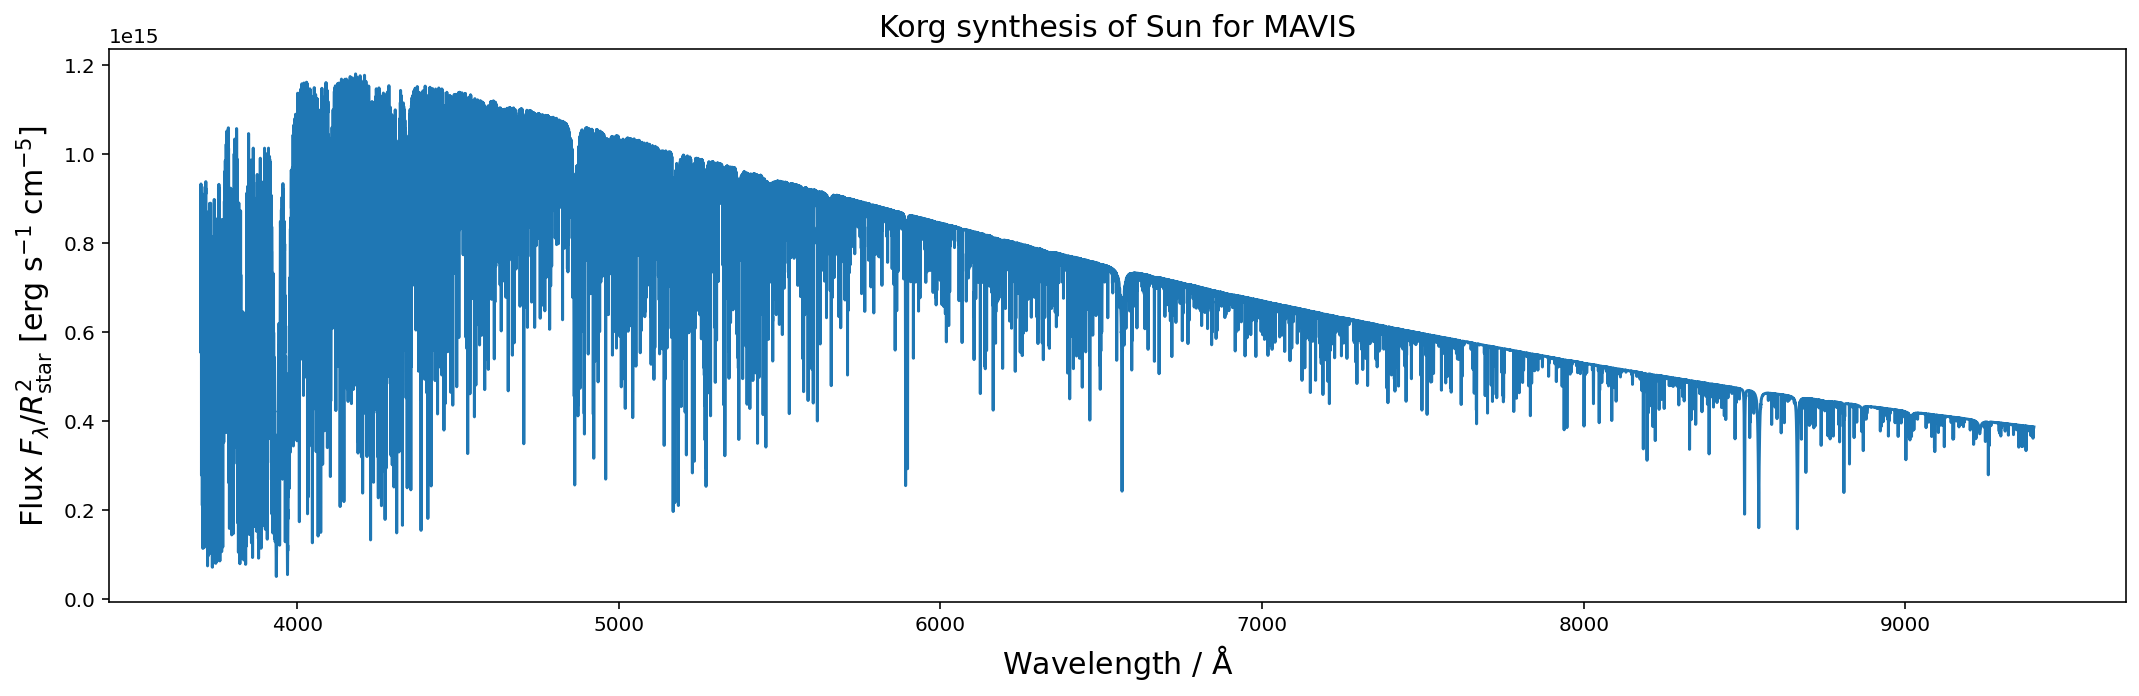

In [7]:
teff = 5772
logg = 4.44
fe_h = 0.00

solar_flux = calculate_korg_spectrum(teff, logg, fe_h, normalise_flux=False, debug=True)
plot_korg_spectrum(solar_flux, plot_title='Korg synthesis of Sun for MAVIS')

Calculating Korg spectrum with fixed parameters:  {'teff': 5772, 'logg': 4.44, 'fe_h': 0.0, 'vmic': 1.0, 'vsini': 5.0, 'epsilon': 0.6}
   --> A(X) scale assumes Asplund et al. (2021), and [alpha/Fe]=-0.0 (i.e. [alpha/H]=0.0)
   --> Interpolating extended MARCS model atmosphere
   --> Synthesising Korg spectrum
   --> Normalising spectrum?  False
   --> Applying rotation
   --> Applying LSF

Computing time:
Computing A(X):           0.0s
Computing Interpolation:  0.0s
Computing Synthesis:      21.2s
Computing Normalisation:  0.0s
Computing Broadening:     0.6s
Computing LSF:            0.0s


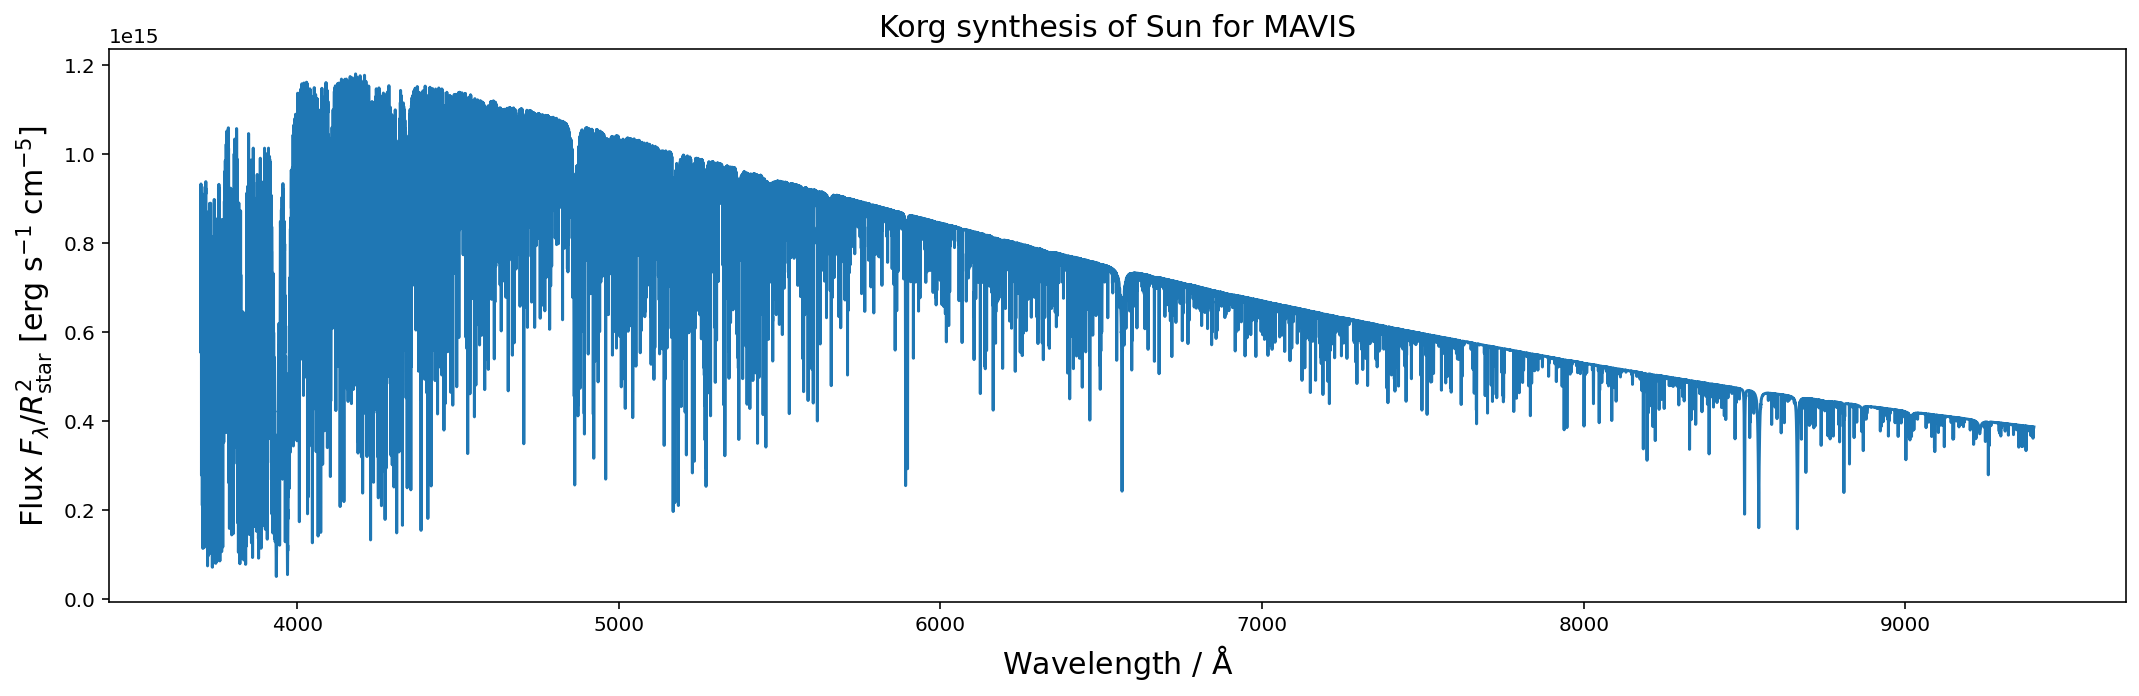

In [8]:
# Do it again to check speed-up
teff = 5772
logg = 4.44
fe_h = 0.00

solar_flux = calculate_korg_spectrum(teff, logg, fe_h, normalise_flux=False, debug=True)
plot_korg_spectrum(solar_flux, plot_title='Korg synthesis of Sun for MAVIS')

Calculating Korg spectrum with fixed parameters:  {'teff': 4330, 'logg': 0.97, 'fe_h': -1.43, 'vmic': 1.9, 'vsini': 5.0, 'epsilon': 0.6}
   --> A(X) scale assumes Asplund et al. (2021), and [alpha/Fe]=0.4 (i.e. [alpha/H]=-1.0299999999999998)
   --> Interpolating extended MARCS model atmosphere
   --> Synthesising Korg spectrum
   --> Normalising spectrum?  False
   --> Applying rotation
   --> Applying LSF

Computing time:
Computing A(X):           0.0s
Computing Interpolation:  0.1s
Computing Synthesis:      34.9s
Computing Normalisation:  0.0s
Computing Broadening:     0.6s
Computing LSF:            0.0s


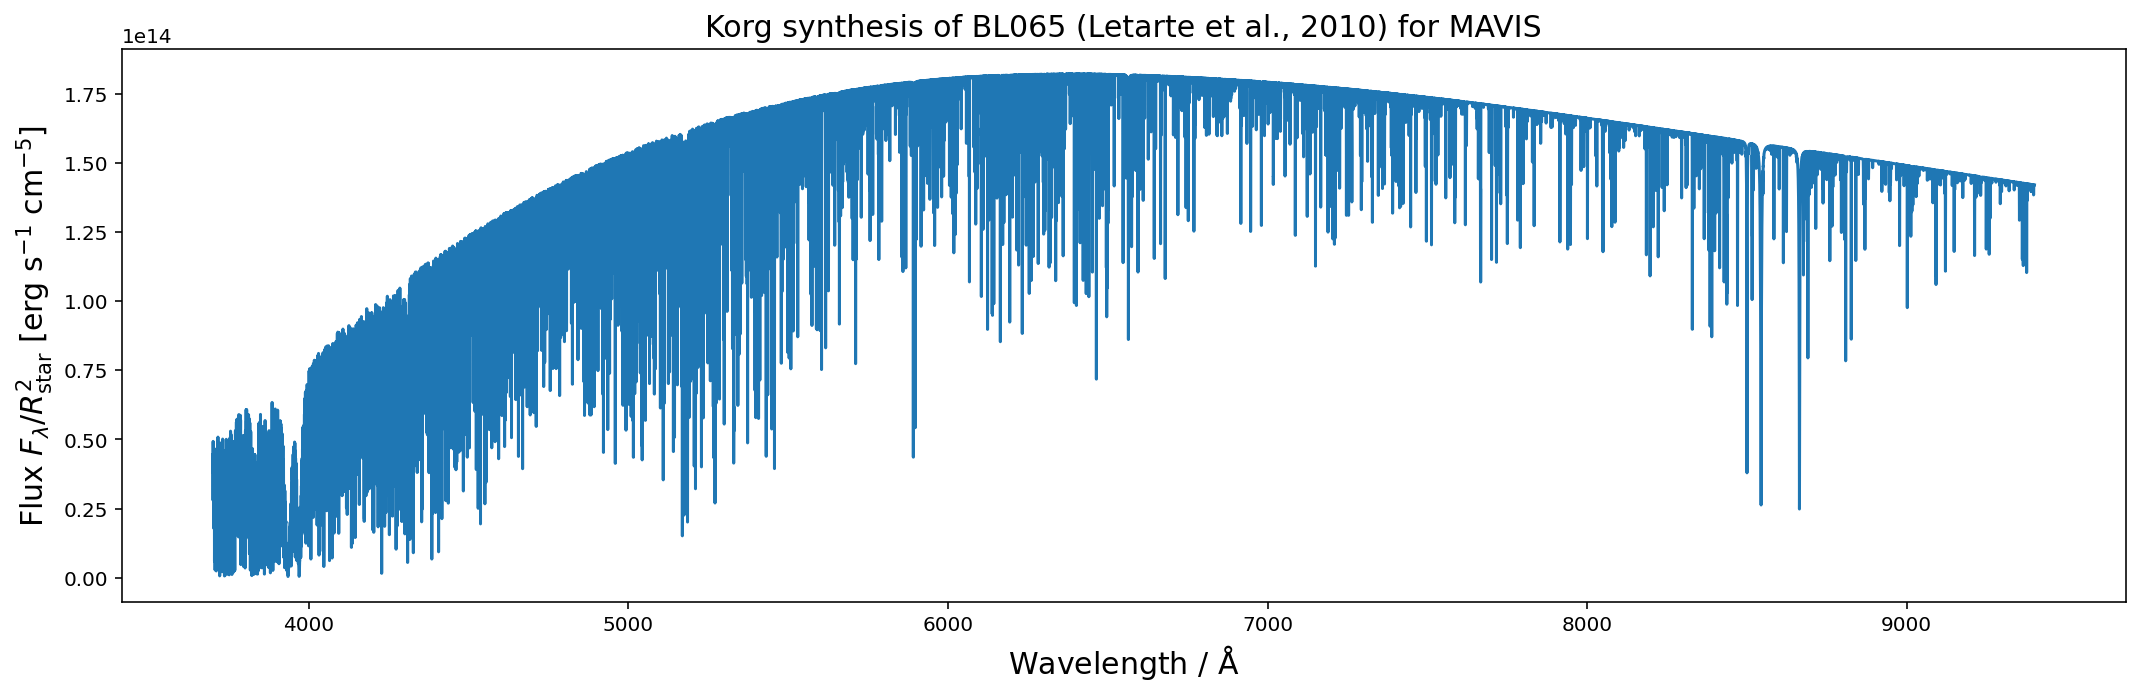

In [9]:
# Now computing spectrum for example star BL065 of Fornax with stellar parameters 
# from Letarte et al. (2010, http://adsabs.harvard.edu/abs/2010A%26A...523A..17L)
teff = 4330
logg = 0.97
fe_h = -1.43
vmic = 1.9

bl065_flux = calculate_korg_spectrum(teff, logg, fe_h, vmic, normalise_flux=False, debug=True)
plot_korg_spectrum(bl065_flux, plot_title='Korg synthesis of BL065 (Letarte et al., 2010) for MAVIS')